# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

---

## Zestaw zadań 7: Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL (część 1)

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [3]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
NORMALIZE_LENGTH = 1000 #because epsg2180 units are meters and we expect kilometers in exercises
NORMALIZE_AREA = NORMALIZE_LENGTH**2

In [4]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań
def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    a = (x_lim[1] - x_lim[0]) * (y_lim[1] - y_lim[0])
    n = np.random.poisson(intensity * a, 1)[0]
    df = []
    
    for nn in range(n):
        df.append([np.random.uniform(x_lim[0], x_lim[1]), np.random.uniform(y_lim[0], y_lim[1])])
        
    return pd.DataFrame(data=df, columns=["X", "Y"])


### Zadanie 1: Import i przygotowanie danych (9 pkt)

Wykorzystując funkcję `geopandas.read_file()` zaimportuj do notatnika dane z trzech dołączonych do niego plików. Następnie, wykorzystując funkcję `geopandas.GeoDataFrame()` przygotuj na ich podstawie trzy tablice z danymi:

1) Tablica zawierająca wybrane dane dotyczące województw:
    - "Nazwa" - nazwy województw
    - "geometry" - geometria obiektów
<br/>
<br/>
2) Tablica zawierającąa wybrane dane dotyczące <u>miast</u>:
    - "Nazwa" - nazwy miast
    - "geometry" - geometria obiektów
<br/>
<br/>
2) Tablica zawierająca wybrane dane dotyczące <u>Wisły</u> i <u>Odry</u>:
    - "Nazwa" - nazwy rzek
    - "geometry" - geometria obiektów


Wyświetl przygotowane tablice.

Uwaga 1: Pliki zawierają więcej danych niż opisane wyżej tablice. W wynikowych tablicach nie powinny znaleźć się zbędne dane.
    
Uwaga 2: Poprawny import polskich nazw może wymagać ustawienia odpowiedniej wartości argumentu `encoding` podczas wywoływania funkcji `geopandas.read_file()`.

In [5]:
gdf = gpd.read_file("Wojewodztwa.zip")
df_wojewodztwa = gpd.GeoDataFrame({"Nazwa": gdf["JPT_NAZWA_"], "geometry":gdf["geometry"]})

In [6]:
gdf = gpd.read_file("Miejscowosci.zip")
gdf = gdf[gdf["rodzaj"] == "miasto"]
df_miasta = gpd.GeoDataFrame({"Nazwa": gdf["nazwaGlown"], "geometry":gdf["geometry"]})
df_miasta = df_miasta.reset_index(drop = True)

In [7]:
gdf = gpd.read_file("Rzeki.zip")
gdf = gdf[gdf["NAZ_RZEKI"].isin(("Wisła", "Odra"))]
df_rzeki = gpd.GeoDataFrame({"Nazwa": gdf["NAZ_RZEKI"], "geometry":gdf["geometry"]})

### Zadanie 2: Transformacja między odwzorowaniami kartograficznymi (3 pkt)

Wczytywane dane są zapisane z wykorzystaniem różnych odwzorowań kartograficznych. Przed rozpoczęciem analizy należy je ze sobą uzgodnić.

Korzystając z własności obiektów GeoDataFrame `geopandas.GeoDataFrame.crs` sprawdzć odwzorowanie kartograficzne, w którym zapisane są poszczególne tablice. Jeżeli odwzorowanie jest inne niż epsg:2180 dokonaj jego konwersji z wykorzystaniem funkcji `geopandas.GeoDataFrame.to_crs()`.

In [8]:
print(df_wojewodztwa.crs, df_miasta.crs, df_rzeki.crs, sep="\n", end="\n\n")
df_wojewodztwa = df_wojewodztwa.to_crs(crs = "epsg:2180")
df_rzeki = df_rzeki.to_crs(crs = "epsg:2180")
print(df_wojewodztwa.crs, df_miasta.crs, df_rzeki.crs, sep="\n")

epsg:9702
epsg:2180
epsg:4326

epsg:2180
epsg:2180
epsg:2180


### Zadanie 3: Wizualizacja danych wejściowych (3 pkt)

Korzystając z funkcji pakietu matplotlib oraz funkcji `geopandas.GeoDataFrame.plot()` zwizualizuj komplet przygotowanych danych. Ustaw parametry wykresu oraz wizualizowanych obiektów (wielkość figury, kolory, grubość linii, wielkość punktów itp.) tak aby wygenerowana mapa była przejrzysta i czytelna.

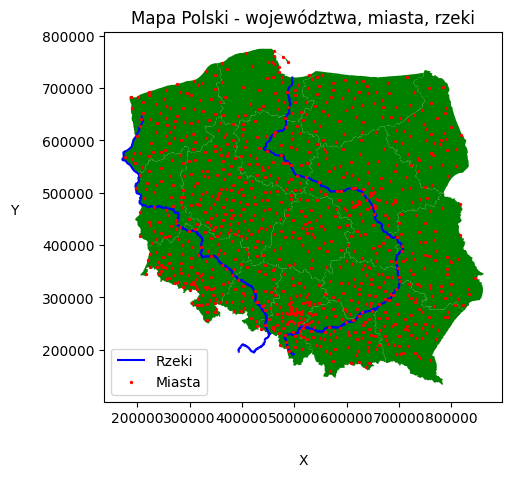

In [9]:
_, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("X", rotation=0, labelpad=20)
ax.set_ylabel("Y", rotation=0, labelpad=20)
plot_wojewodztwa = df_wojewodztwa.plot(ax = ax, color = "green", zorder = 1)
plot_rzeki = df_rzeki.plot(ax = ax, markersize = 5, color = "blue", zorder = 2, label = "Rzeki")
plot_miasta = df_miasta.plot(ax = ax, color = "red", markersize = 2, zorder = 3, label = "Miasta")
plt.title("Mapa Polski - województwa, miasta, rzeki")
plt.legend()
plt.show()

### Zadanie 4: Mierzenie długości, pola powierzcploti i odległości (10 pkt)

#### a) Długość Wisły
Korzystając z własności `geopandas.GeoSeries.length` zmierz długość Wisły. Wyświetl odpowiedź podając długość rzeki w kilometrach.

In [10]:
print("Wisła ma długość", df_rzeki[df_rzeki["Nazwa"] == "Wisła"]["geometry"].length[1]/NORMALIZE_LENGTH, "km.")

Wisła ma długość 1019.7577991167121 km.


#### b) Pola powierzchni województw
Korzystając z własności `geopandas.GeoSeries.area` zmierz powierzchnię województw. Zapisz wyniki do tablicy w kolumnie o nazwie "Pole". 
Następnie wykorzystaj dane do odpowiedzenia na pytanie jakie jest pole powierzchni Polski (podaj pole w kilometrach kwadratowych) oraz przygotowania wizualiacji, na której kolor przypisany województwom jest powiązany z ich powierzchnią. Ustaw parametry wykresu oraz wizualizowanych obiektów (wielkość figury, kolory, grubość linii, wielkość punktów itp.) tak aby wygenerowana mapa była przejrzysta i czytelna.

In [11]:
pola = df_wojewodztwa["geometry"].area
df_wojewodztwa = df_wojewodztwa.assign(Pole = pola)
print("Pole powierzchni Polski wynosi ", sum(df_wojewodztwa["Pole"])/NORMALIZE_AREA, "km².")

Pole powierzchni Polski wynosi  312506.6445773843 km².


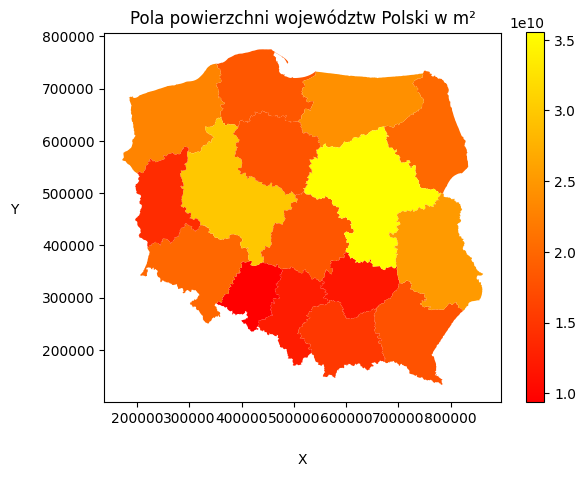

In [12]:
_, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("X", rotation=0, labelpad=20)
ax.set_ylabel("Y", rotation=0, labelpad=20)
df_wojewodztwa.plot(column = "Pole", ax = ax, legend = True, cmap="autumn")
plt.title("Pola powierzchni województw Polski w m²")
plt.show()

#### c) Odległość miast od Krakowa
Korzystając z funkcji `geopandas.GeoSeries.distance()` zmierz odległość poszczególnych miast od Krakowa. Zapisz wyniki do tablicy w kolumnie o nazwie "Odległość od Krakowa". 
Następnie wykorzystaj dane do odpowiedzenia na pytanie w jakiej odległości od Krakowa leży Poznań (odpowiedź podaj w kilometrach) oraz przygotowania wizualiacji, na której kolor przypisany miastom jest powiązany z ich odległością od Krakowa. 

Wizualizacja powinna zawierać:
- kontury województw, bez wypełnienia,
- lokalicaje miast.

Ustaw parametry wykresu oraz wizualizowanych obiektów (wielkość figury, kolory, grubość linii, wielkość punktów itp.) tak aby wygenerowana mapa była przejrzysta i czytelna.

In [13]:
krakow_ind = df_miasta[df_miasta["Nazwa"] == "Kraków"].index.tolist()[0]
krakow = df_miasta[df_miasta["Nazwa"] == "Kraków"]["geometry"][krakow_ind]
distances = df_miasta["geometry"].distance(krakow)
df_miasta = df_miasta.assign(**{"Odległość od Krakowa" : distances})
df_miasta
print("Odległość Poznania od Krakowa wynosi", df_miasta[df_miasta["Nazwa"]=="Poznań"]["Odległość od Krakowa"][609]/1000, "km.")

Odległość Poznania od Krakowa wynosi 334.60495145299524 km.


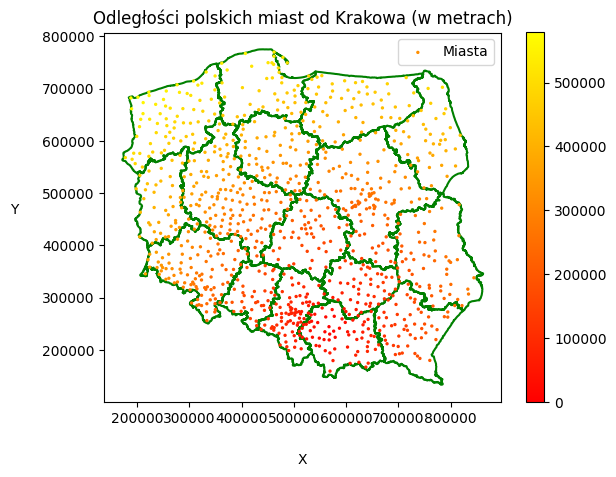

In [14]:
_, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("X", rotation=0, labelpad=20)
ax.set_ylabel("Y", rotation=0, labelpad=20)
plot_wojewodztwa = df_wojewodztwa.boundary.plot(ax = ax, color = "green", zorder = 1)
plot_miasta = df_miasta.plot(column = "Odległość od Krakowa", ax = ax, legend = True, cmap="autumn", markersize = 2, zorder = 2, label = "Miasta")
plt.title("Odległości polskich miast od Krakowa (w metrach)")
plt.legend()
plt.show()

### Zadanie 5: Wykorzystanie prostych operacji geometrycznych (12 pkt)

#### a) Miasta blisko Wisły

Korzystając z funkcji `geopandas.GeoSeries.buffer()` oraz `geopandas.GeoSeries.within()` sprawdź, które miast leżą bliżej niż 20 km od Wisły. Zapisz wyniki do tablicy w kolumnie o nazwie "Blisko Wisły". 
Następnie wykorzystaj dane do odpowiedzenia na pytanie ile miast leży bliżej niż 20 km od Wisły oraz przygotowania wizualiacji, na której oznaczony zostanie obszar znajdujący się bliżej niż 20 km od Wisły, a znajdujące się w tym obszarze miasta będą wyróżnione kolorem względem pozostałych miast.

Wizualizacja powinna zawierać:
- województwa, wypełnione jednolitym kolorem,
- miasta, w jednym z dwóch wybranych kolorów w zależności od położenia w obrębie lub poza analizowanym obszarem.
- rzeki wypełnione jednolitym kolorem,
- oznaczenie obszaru leżącego nie dalej niż 20 km od Wisły.

Ustaw parametry wykresu oraz wizualizowanych obiektów (wielkość figury, kolory, grubość linii, wielkość punktów itp.) tak aby wygenerowana mapa była przejrzysta i czytelna.

In [15]:
buffer = df_rzeki[df_rzeki["Nazwa"] == "Wisła"]["geometry"].buffer(20*NORMALIZE_LENGTH)
buffer_df = gpd.GeoSeries(data = np.repeat(buffer, len(df_miasta)))
df_miasta = df_miasta.assign(**{"Blisko Wisły" : df_miasta["geometry"].within(buffer_df, align = False)})
print(len(df_miasta[df_miasta["Blisko Wisły"] == True]), "miast leży bliżej niż 20km od Wisły.")

148 miast leży bliżej niż 20km od Wisły.


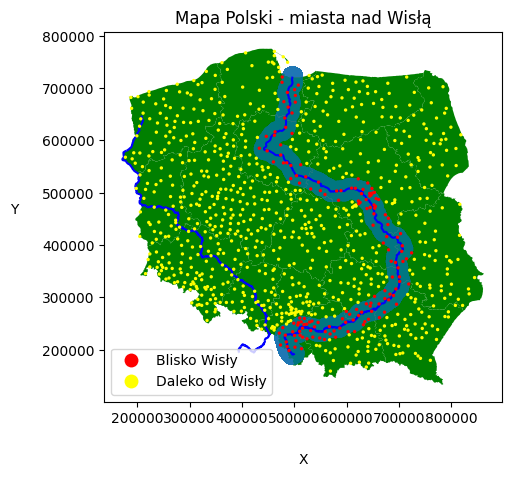

In [16]:
df_miasta.loc[df_miasta["Blisko Wisły"] == True, "Blisko Wisły"] = "Blisko Wisły"
df_miasta.loc[df_miasta["Blisko Wisły"] == False, "Blisko Wisły"] = "Daleko od Wisły"
_, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("X", rotation=0, labelpad=20)
ax.set_ylabel("Y", rotation=0, labelpad=20)
plot_wojewodztwa = df_wojewodztwa.plot(ax = ax, color = "green", zorder = 1)
plot_rzeki = df_rzeki.plot(ax = ax, markersize = 5, color = "blue", zorder = 2, label = "Rzeki")
plot_miasta = df_miasta.plot(column = "Blisko Wisły", ax = ax, markersize = 2, zorder = 3, label = "Miasta", legend = True, categorical = True, cmap = "autumn")
plot_bufor = buffer_df.plot(ax = ax, alpha = 0.02)
plt.title("Mapa Polski - miasta nad Wisłą")
plt.show()

#### b) Województwa, przez które przepływa Odra
Korzystając z funkcji `geopandas.GeoSeries.intersects()` sprawdź, przez które województwa przepływa Odra. Zapisz wyniki do tablicy w kolumnie o nazwie "Odra w obrębie". 
Następnie wykorzystaj dane do odpowiedzenia na pytanie przez ile województw przepływa Odra oraz przygotowania wizualiacji, na której województwa przez które przepływa Odra będą wyróżnione kolorem względem pozostałych województw.

Wizualizacja powinna zawierać:
- województwa, wwypełnione jednym z dwóch wybranych kolorów w zależności od spełnienia warunku,
- miasta, wypełnione jednolitym kolorem,
- rzeki wypełnione jednolitym kolorem.

Ustaw parametry wykresu oraz wizualizowanych obiektów (wielkość figury, kolory, grubość linii, wielkość punktów itp.) tak aby wygenerowana mapa była przejrzysta i czytelna.

In [17]:
df_odra = gpd.GeoSeries(data = np.repeat(df_rzeki[df_rzeki["Nazwa"] == "Odra"]["geometry"], len(df_wojewodztwa)))
df_wojewodztwa = df_wojewodztwa.assign(**{"Odra w obrębie" : df_wojewodztwa["geometry"].intersects(df_odra, align = False)})
print("Odra przepływa przez", len(df_wojewodztwa[df_wojewodztwa["Odra w obrębie"] == True]), "województw.")

Odra przepływa przez 5 województw.


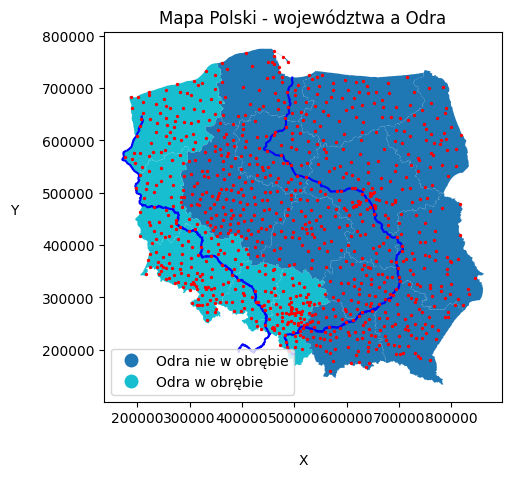

In [18]:
df_wojewodztwa.loc[df_wojewodztwa["Odra w obrębie"] == True, "Odra w obrębie"] = "Odra w obrębie"
df_wojewodztwa.loc[df_wojewodztwa["Odra w obrębie"] == False, "Odra w obrębie"] = "Odra nie w obrębie"
_, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("X", rotation=0, labelpad=20)
ax.set_ylabel("Y", rotation=0, labelpad=20)
plot_wojewodztwa = df_wojewodztwa.plot(column = "Odra w obrębie", ax = ax, zorder = 1, legend = True)
plot_rzeki = df_rzeki.plot(ax = ax, markersize = 5, color = "blue", zorder = 2, label = "Rzeki")
plot_miasta = df_miasta.plot(ax = ax, color = "red", markersize = 2, zorder = 3, label = "Miasta")
plt.title("Mapa Polski - województwa a Odra")
plt.show()

### Zadanie 6: Generowanie procesu punktowego w obrębie poligonu (13 pkt)

Przygotuj funkcję `homogeneous_poisson_on_polygon()`, która będzie wykorzystywała funkcję `homogeneous_poisson_on_rectangle()` przygotową w ramach pierwszego zestawu zadań oraz możliwości pakietu geopandas do generowania jednorodnego rozkładu Poissona w obrębie dowolnego poligonu.

Następnie wykorzystaj funkcję do wygenerowania rozkładu punktów o intensywności $10^{-8} pkt/m^2$ na obszarze województwa mazowieckiego i zwizualizuj wyniki. Ustaw parametry wykresu oraz wizualizowanych obiektów (wielkość figury, kolory, grubość linii, wielkość punktów itp.) tak aby wygenerowana mapa była przejrzysta i czytelna.

Przydatne funkcje i własności:
- `geopandas.GeoSeries.bounds`
- `geopandas.GeoSeries.from_xy()`
- `geopandas.GeoSeries.set_crs()`
- `geopandas.GeoSeries.within()`

#### a) Przygotowanie funkcji

In [23]:
def homogeneous_poisson_on_polygon(intensity, polygon):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    polygon: Polygon
        Obszar, na którym mają zostać wygenerowane punkty.
    
    Returns
    -------
    points: GeoDataFrame
        Tablica zawierająca kolumnę "geometry" ze współrzędnymi punktów w odwzorowaniu kartograficznym identycznym jak odwzorowanie zmiennej polygon.
    """
    crs = polygon.crs
    bounds = polygon.bounds
    x_lim = [*bounds["minx"], *bounds["maxx"]]
    y_lim = [*bounds["miny"], *bounds["maxy"]]
    data = homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim)
    square_polygon = gpd.GeoSeries.from_xy(data["X"], data["Y"], crs = crs)
    polygon_df = gpd.GeoSeries(data = np.repeat(polygon, len(square_polygon)))
    square_polygon = square_polygon[square_polygon.within(polygon_df, align = False)]
    return gpd.GeoDataFrame(data = square_polygon, crs = crs, geometry = square_polygon)

#### b) Wygenerowanie procesu

In [24]:
mazowieckie = df_wojewodztwa[df_wojewodztwa["Nazwa"] == "mazowieckie"]["geometry"]
homogenous_poisson_on_mazowieckie = homogeneous_poisson_on_polygon(intensity = 1e-8, polygon = mazowieckie)

#### c) Wizualizacja

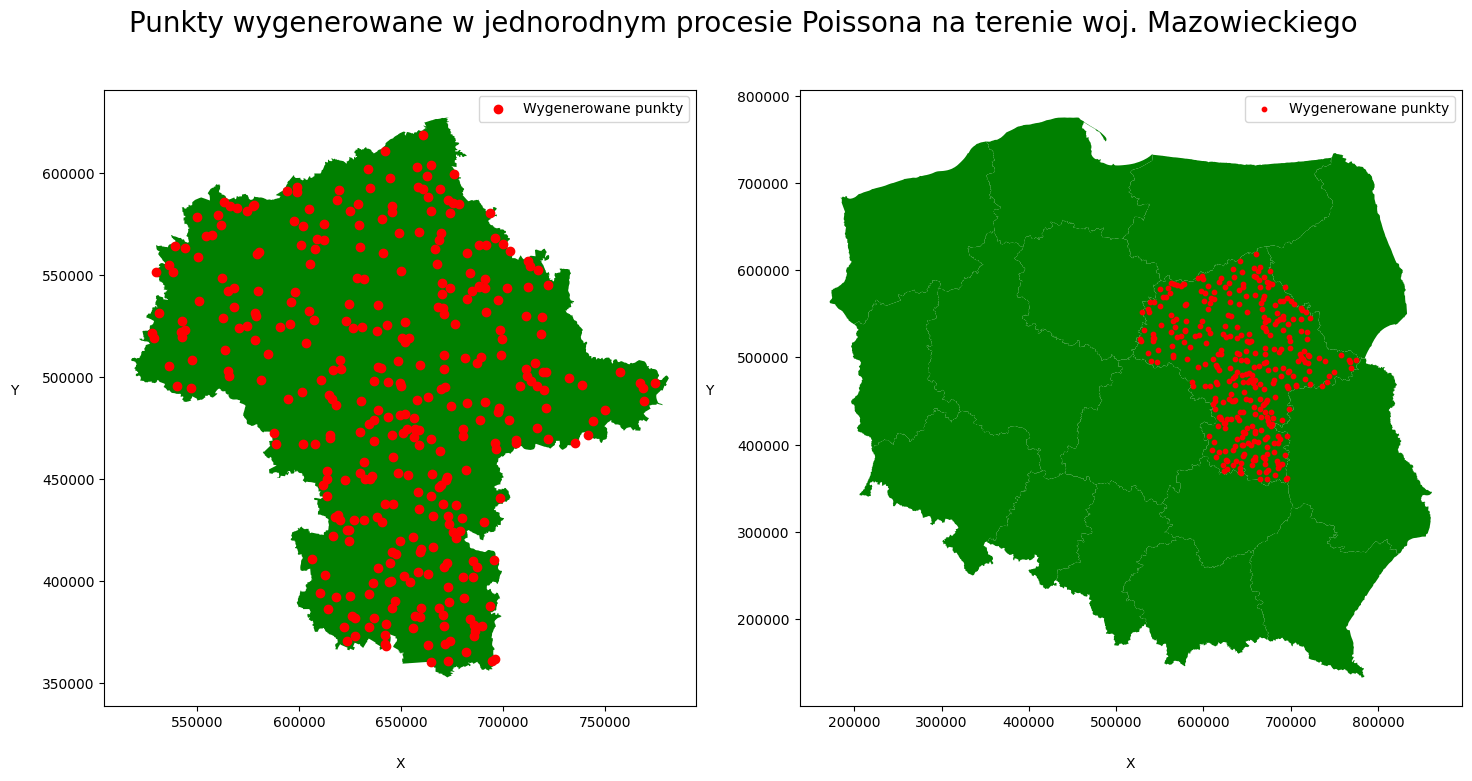

In [21]:
_, ax = plt.subplots(1, 2, figsize=[18,8])
plt.subplots_adjust(hspace = 0.1, wspace = 0.1)

ax[0].set_aspect("equal", "box")
ax[1].set_aspect("equal", "box")

ax[0].set_xlabel("X", rotation=0, labelpad=20)
ax[0].set_ylabel("Y", rotation=0, labelpad=20)

ax[1].set_xlabel("X", rotation=0, labelpad=20)
ax[1].set_ylabel("Y", rotation=0, labelpad=20)

mazowieckie.plot(ax = ax[0], color = "green", zorder = 1)
homogenous_poisson_on_mazowieckie.plot(ax = ax[0], color = "red", zorder = 2, label = "Wygenerowane punkty")

df_wojewodztwa.plot(ax = ax[1], color = "green", zorder = 1)
homogenous_poisson_on_mazowieckie.plot(ax = ax[1], color = "red", markersize = 10, zorder = 2, label = "Wygenerowane punkty")

ax[0].legend()
ax[1].legend()

plt.suptitle("Punkty wygenerowane w jednorodnym procesie Poissona na terenie woj. Mazowieckiego", fontsize = 20)
plt.show()